<figure>
  <IMG SRC="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d5/Fachhochschule_Südwestfalen_20xx_logo.svg/320px-Fachhochschule_Südwestfalen_20xx_logo.svg.png" WIDTH=250 ALIGN="right">
</figure>

# Das Gradientenverfahren


In diesem Aufgabenblatt geht es darum, das Gradientenverfahren mithilfe der NumPy Funktionen in Python zu implementieren.

Bevor wir aber starten, installieren wir Python Bibliotheken, die wir im weiteren Verlauf benötigen.

In [1]:
!pip install numpy matplotlib

Wir verwenden einen synthetischen Datensatz mit nur einer unabhängigen Variablen auf den wir ein univariates Regressionsmodell anwenden.

In der folgenden Code-Zelle importieren wir die Testdaten `X` sowie die Labels `y`. Die Ausgabe zeigt die ersten 10 Zeilen des Datensatzes.
Wie Sie sehen, ist `X` bereits um eine Spalte von Einsen erweitert, damit wir den Bias-Parameter zusammen mit den Merkmals-Parametern behandeln können.

In [2]:

import numpy as np
size = 1000
mux = 0
stdx = 10
X = np.random.normal(mux,stdx,size)
shiftx = np.min(X)
X = X.reshape(size,1)
stdnoise = 10.2
noise = np.random.normal(0,stdnoise,size)
noise = noise.reshape(size,1)
y = 12 + 4.4*X + noise
x0 = (np.ones(size)).reshape(size,1)
X = np.concatenate((x0, X), 1)

print("X = ", X[0:10,])
print("y = ", y[0:10,])

X =  [[  1.          -8.19375171]
 [  1.         -11.90388591]
 [  1.           5.23150017]
 [  1.          15.128955  ]
 [  1.          -9.77394099]
 [  1.          -3.9820053 ]
 [  1.          16.53785336]
 [  1.         -10.03034917]
 [  1.         -21.90110693]
 [  1.          -2.90022403]]
y =  [[-18.04349056]
 [-42.15419893]
 [ 43.61494671]
 [ 69.72928288]
 [-47.17995946]
 [ -0.88369719]
 [ 96.65803949]
 [-27.6464375 ]
 [-92.54584811]
 [  6.71925475]]


## Modellfunktion, Kostenfunktion und Normalengleichung für die lineare Regression

Wir definieren nun 3 elementare Funktionen für die lineare Regression:
Die Modellfunktion `h`, die Kostenfunktion `J` und die Normalengleichung.

Bevor wir jedoch in die Programmierung dieser Funktionen einsteigen, nochmal einige Hinweise zu Python und NumPy:

- Da wir für die Daten NumPy Arrays verwenden, können wir die Matrixoperationen von NumPy nutzen. `A.T` etwa liefert die **transponierte** Matrix von `A`. `A@B` berechnet die Matrixmultiplikation von `A` und `B`. Sollten Sie sich einmal nicht sicher sein, wie viele Zeilen und Spalten eine Matrix `A` besitzt, können Sie sich mit `np.shape(A)` die Dimensionen anzeigen lassen.

- Auch wenn das Ergebnis `A` eine Matrixoperation ein einzelner Wert ist, ist der Datentyp des Resultats eine `1x1`-Matrix. Um an den Wert zu gelangen, müssen Sie auf `A[0,0]` oder `A[0][0]` zugreifen. Alternativ können Sie mit Alternativ können Sie mit `A.item(i)` den `i`-ten Wert aus der Matrix abfragen.

- Um eine Matrix `A` zu invertieren, benutzen Sie die NumPy-Funktion `inv()` aus dem Paket `linalg`. Wir benutzen diese Funktion bei der Berechnung der Normalgleichung.

Um die Modellfunktion `h` auszurechnen, müssen wir alle Werte im Merkmalsvektor mit den entsprechenden Modellparametern multiplizieren und die Ergebnisse aufsummieren.
Dies entspricht dem Skalarprodukt (*dot product*) der beiden Vektoren.

Betrachten wir nochmal unsere Daten-Matrix $X$.
in den $m$ Zeilen von $X$ sind einzelne Datenpunkte.
Ein Datenpunkt besteht aus $n$ Werten, die in einem Merkmalsvektor $(x_1, x_2, ..., x_n)$ zusammengefasst sind.
Zur Vereinfachung tragen wir eine $1$ an die erste Position des Vektors ein. Diesen Wert bezeichnen wir mit $x_0$, er dient zur einfacheren Berechnung des Bias-Terms.

Wenn nun ein Merkmalsvektor $x$ ein Zeilenvektor ist, und der Parametervektor $\theta$ ein Spaltenvektor mit gleich vielen Einträgen, kann man das Skalarprodukt als Matrixmultiplikation von $x$ und $\theta$ berechnen.

In [3]:
def h(x,theta):
    return x@theta

Praktischerweise funktioniert die gleiche Funktion nuicht nur für Merkmalsvektoren, sondern die gesamte Daten-Matrix `X`.
In diesem Fall ist das Ergebnis der Multiplikation $X\theta$ ein Spaltenvektor $y$ mit $m$ Werten $y^{(i)}$, die den Vorhersagen der abhängigen Variablen der einzelnen Datenpunkte entsprechen.

Ein Beispiel: Betrachten Sie folgenden NumPy Arrays.
`X0` ist eine $8\times{}2$ Matrix die 8 Datenpunkte mit einem Merkmal plus den vorangestellten Einser-Vektor enthält.
`y0` ist ein Spaltenvektor mit Beobachtungen für die abhängige Variable.
Wir wollen in den nächsten Schritten den *verkleinerten* Datensatz aus `X0` und `y0` verwenden, um die Funktionen zu entwickeln und zu überprüfen.
Für das Gradientenverfahren benutzen wir später den großen Datensatz aus `X` und `y`.

In [4]:
X0 = np.array([[1,1],[1,2],[1,3],[1,4],[1,5],[1,6],[1,7],[1,8]])
y0 = np.array([[2],[4],[4],[6],[6],[6],[8],[8]])

Als 2D-Plot sieht die Verteilung der Datenpunkte so aus:

(0.0, 9.0)

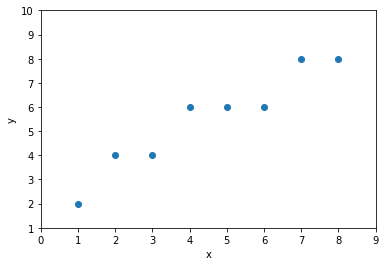

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.scatter(X0[:,1],y0)
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(1,10)
plt.xlim(0,9)

Man sieht hier schon, das eine lineare Funktion, die die Punkte recht gut beschreiben würde, den Achsenabschnitt $1$ und die Steigung $1$ hat.
Daher ist der Vektor $(1,1)$ eine gute Schätzung für $\theta$.

In [6]:
theta = np.array([[1],[1]])
y_hat = h(X0,theta)
y_hat

array([[2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8],
       [9]])

Wie wir im folgenden Plot sehen, liefert unser geschätztes $\theta$ eine recht gute Modellfunktion

(0.0, 9.0)

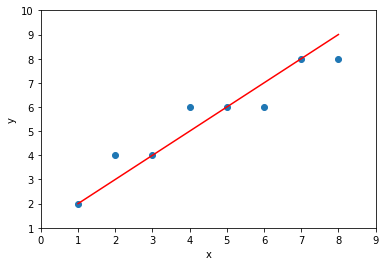

In [7]:
plt.scatter(X0[:,1],y0)
plt.plot(X0[:,1],y_hat,c='r')
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(1,10)
plt.xlim(0,9)

Nun müssen wir noch die Kostenfunktion $J_{MSE}(X,\theta)$ berechnen.
Laut Definition berechnet sich $J_{MSE}$ wie folgt:

$J_{MSE}(X,\theta)=\frac{1}{m}\sum_{i=1}^m ( h(x,\theta)-y^{(i)})^2$

Wir müssen also von der Vorhersage unseres Modells $h(x,\theta)$ die tatsächlich beobachteten Werte $y^{(i)}$ abziehen, das Resultat quadrieren, die Ergebnisse für alle $m$ Datenpunkte aufadieren und normieren.

Auch in diesem Fall können wir wieder einen Trick anwenden, um die Summe zu umgehen.
Wenn wir $h(X,\theta)$ für die gesamte Matrix $X$ ausrechnen, bekommen wir einen kompletten *Schätzvektor* $\hat{y}$.
Von diesem können wir den Vektor $y$ abziehen und erhalten als Ergebnis wieder einen Vektor mit $m$ Werten.

Nun müssen wir die einzelnen Werte in diesem Vektor quadrieren und aufsummieren.
Auch hier hilft uns wieder das Skalarprodukt!
Das Skalarprodukt $x\cdot{}x$ multipliziert jeden Wert in $x$ mit sich selber und summiert alle Teilergebnisse auf.
Wenn wir aus dem Spaltenvektor $x$ mit $x^T$ einen Zeilenvektor machen, können wir das Skalarprodukt als Matrixmultiplikation $x^Tx$ ausrechnen.

Die Definition von $J_{MSE}(X,\theta)$ vereinfacht sich also zu folgender Form:

$J_{MSE}(X,\theta)=\frac{1}{m}d^Td$,    mit    $d=h(x,\theta)-y)$


In [8]:
def J_mse(x, y, theta):
    d = h(x,theta)-y
    r = d.T@d / len(x)
    return r.item(0)

Für den Datensatz `X0` und `y0` mit der Parameterschätzung $(1,1)$, liefert unsere Funktion $J_{MSE}$ folgende Kosten

In [9]:
J_mse(X0,y0,theta)

0.5

Nun wollen wir eine Funktion zur Berechnung der Normalengleichung definieren.
Mit dieser Funktion können die optimalen Parameter $\theta$ direkt berechnet werden.
Die Normalengleichung ist folgendermaßen definiert:

$\hat{\theta}=(X^TX)^{-1}X^Ty$

**Aufgabe: Implementieren Sie die Funktion `normalengleichung`.**

In [10]:
def normalgleichung(X, y):
    return np.linalg.inv(X.T @ X) @ X.T @ y

**Frage: Welches Ergebnis liefer die Normalengleichung für unseren Datensatz `X0`, `y0`?**

**Frage: War unsere Schätzung $\theta=(1,1)$ optimal?**

In [11]:
t = normalgleichung(X0, y0)
t

array([[1.85714286],
       [0.80952381]])

In [12]:
J_mse(X0,y0,t)

0.3095238095238094

(0.0, 9.0)

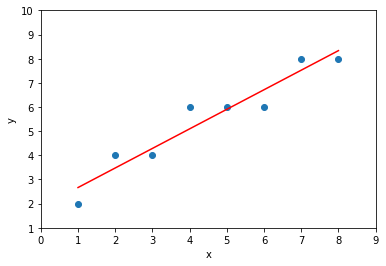

In [13]:
plt.scatter(X0[:,1],y0)
plt.plot(X0[:,1],h(X0,t),c='r')
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(1,10)
plt.xlim(0,9)

## Das Gradientenverfahren

Wir können nun die Normalengleichung verwenden um die optimalen Parameter für unseren großen Datensatz $X$ und $y$ zu bestimmen

**Verwenden Sie die Funktion `Normalgleichung` um die optimalen Regressionsparameter $\Theta_0$ und $\Theta_1$ zu ermitteln.**

In [14]:
normalgleichung(X, y)

array([[12.26331105],
       [ 4.46510929]])

Nun haben wir die exakten Werte für unsere Regressionsparameter $\Theta_0$ und $\Theta_1$ bestimmt.
Im Folgenden wollen wir nun das **Gradientenverfahren** verwenden, um eine Annäherung dieser Parameter iterativ zu berechnen.

Lesen Sie zum besseren Verständniss der folgenden Schritte aus dem Kapitel 4 ("*Trainieren von Modellen*") der Lehrbuchs \[1\] den Abschnitt "*Das Gradientenverfahren*" (Seiten 112-121).



**Vervollständigen Sie die Funktion `gradient_descent` um die Berechnung des Gradienten $\frac{1}{m}X^T(X\Theta-y)$**.

In [15]:
def gradient_descent(X, y, theta, alpha, iterationen):
    kosten = []
    for iter in range(iterationen):
        kosten.append(J_mse(X, y, theta))
        gradient = (1/len(y)) * (X.T @ (X @ theta - y))
        theta = theta - (alpha * gradient)
    return theta, kosten

**Testen Sie Ihre Funktion `gradient_descent` mit dem Datensatz.**
**Passen die Ergebnisse zu den zuvor Berechneten optimalen Parametern?**
**Variieren Sie die Lernrate $\alpha$ sowie die Anzahl der Epochen.**

In [16]:
theta_0 = np.random.randn(2,1)
alpha = 0.01

theta_gd, kosten = gradient_descent(X, y, theta_0, alpha, 400)
theta_gd

array([[12.04341767],
       [ 4.46495359]])

Wir können nun die Lernkurve für den letzten Trainingslauf plotten.

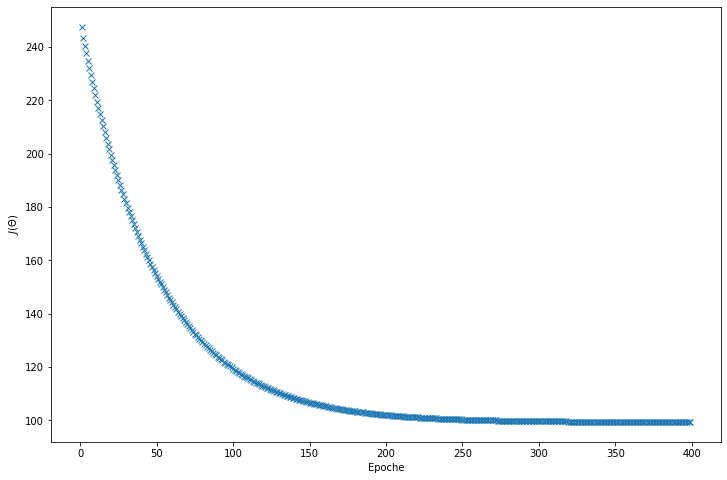

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(12,8))
plt.ylabel(r'$J(\Theta)$')
plt.xlabel(r'Epoche')
plt.plot(range(1,len(kosten)),kosten[1:], "x", label=r'$\alpha='+str(alpha))

**Die Lernrate $\alpha$ ist mir 0.01 sehr gering gewählt. Was passiert, wenn Sie $\alpha$ verändern?**

**Als Abbruchkreterium eine feste Zahl von Iterationen zu wählen ist nicht unbedingt sinnvoll für das Gradientenverfahren. Welche weiteren Abbruchkriterien könnten Sie wählen?**

\[1\] Géron, Aurélien. Praxiseinstieg Machine Learning mit Scikit-Learn und TensorFlow : Konzepte, Tools und Techniken für intelligente Systeme, o'Reilly, 2018. ProQuest Ebook Central, http://ebookcentral.proquest.com/lib/fh-swf/detail.action?docID=5215589.